In [1]:
# Perform contrastive learning on liver ShMOLLI images using 3 positive pairs and 30 negative pairs

import pickle

sub_dcms1 = pickle.load(open('/run/media/anton/Elements/UKB/liver10.pkl', 'rb'))
sub_dcms2 = pickle.load(open('/run/media/anton/Elements/UKB/liver11.pkl', 'rb'))
sub_dcms3 = pickle.load(open('/run/media/anton/Elements/UKB/liver12.pkl', 'rb'))

print(len(sub_dcms1))
print(len(sub_dcms2))
print(len(sub_dcms3))

sub_dcms = sub_dcms1 | sub_dcms2 | sub_dcms3

print(len(sub_dcms))

1659
1669
1667
4995


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math

subs = sorted(list(sub_dcms.keys()))
dcms = []

for sub in subs:
    dcms.append(sub_dcms[sub])

# dcms = dcms[:4000]

orig = torch.from_numpy(np.stack(dcms)).float().cuda()
orig = orig.unsqueeze(1)

flip1 = torch.flip(orig, [2])
flip2 = torch.flip(orig, [3])
flip3 = torch.flip(orig, [2,3])

# print(orig.shape)

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1,10,(7,7),stride=3).float().cuda()
        self.conv2 = nn.Conv2d(10,10,(7,7),stride=3).float().cuda()
        self.conv3 = nn.Conv2d(10,10,(7,7),stride=3).float().cuda()
        self.conv4 = nn.Conv2d(10,10,(7,7),stride=3).float().cuda()
        self.mp = nn.MaxPool2d((1,2)).float().cuda()

    def forward(self, x):
        N = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.mp(x)
        x = x.reshape(N,-1)
        return x

ext = FeatureExtractor()
optim = torch.optim.Adam(ext.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 20000
pperiod = 100
count = 0
tau = 2
npos = 15
nneg = 15
trace = []

for e in range(nepochs):
    # Note: sometimes we can get positive and negative indices to be the same
    # not common though, when npos or nneg << len(orig)
    optim.zero_grad()
    posi = np.random.randint(low=0, high=len(orig), size=(npos))
    q = ext(orig[posi])
    k1 = ext(flip1[posi])
    k2 = ext(flip2[posi])
    k3 = ext(flip3[posi])
    qk1 = torch.einsum('na,na->n',q,k1)
    qk2 = torch.einsum('na,na->n',q,k2)
    qk3 = torch.einsum('na,na->n',q,k3)
    qpn = torch.stack([qk1, qk2, qk3], dim=1)
    pos = torch.sum(torch.exp(qpn/tau), dim=1)
    negi = np.random.randint(low=0, high=len(orig), size=(nneg))
    k0n = ext(orig[negi])
    k1n = ext(flip1[negi])
    k2n = ext(flip2[negi])
    k3n = ext(flip3[negi])
    qk0n = torch.einsum('na,ma->nm',q,k0n).reshape(npos,-1)
    qk1n = torch.einsum('na,ma->nm',q,k1n).reshape(npos,-1)
    qk2n = torch.einsum('na,ma->nm',q,k2n).reshape(npos,-1)
    qk3n = torch.einsum('na,ma->nm',q,k3n).reshape(npos,-1)
    qkn = torch.cat([qk0n, qk1n, qk2n, qk3n], dim=1)
    neg = torch.sum(torch.exp(qkn/tau), dim=1)
    loss = -torch.sum(torch.log(pos/(pos+neg)))
    if math.isnan(float(loss)):
        print('continuing')
        continue
    loss.backward()
    optim.step()
    trace.append(float(loss))
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')

print('Done')

0 46.179386138916016
100 39.168235778808594
200 36.531463623046875
300 39.69261932373047
400 38.20795822143555
500 31.584352493286133
600 42.502357482910156
700 41.915672302246094
800 36.454933166503906
900 26.776302337646484
1000 25.1138916015625
1100 35.389305114746094
1200 23.962661743164062
1300 25.020105361938477
1400 32.919036865234375
1500 25.562395095825195
1600 34.457183837890625
1700 31.042530059814453
1800 26.91727066040039
1900 24.813758850097656
2000 34.496238708496094
2100 24.349349975585938
2200 29.568817138671875
2300 14.58153247833252
2400 26.636085510253906
2500 16.611766815185547
2600 16.372943878173828
2700 21.276891708374023
2800 15.140433311462402
2900 19.76266860961914
3000 22.092254638671875
3100 17.047340393066406
3200 18.363027572631836
3300 14.348119735717773
3400 19.120710372924805
3500 21.470123291015625
3600 9.236557960510254
3700 13.59900951385498
3800 16.777206420898438
3900 16.134334564208984
4000 6.9470672607421875
4100 13.440881729125977
4200 22.27678

In [16]:
len(orig)

20

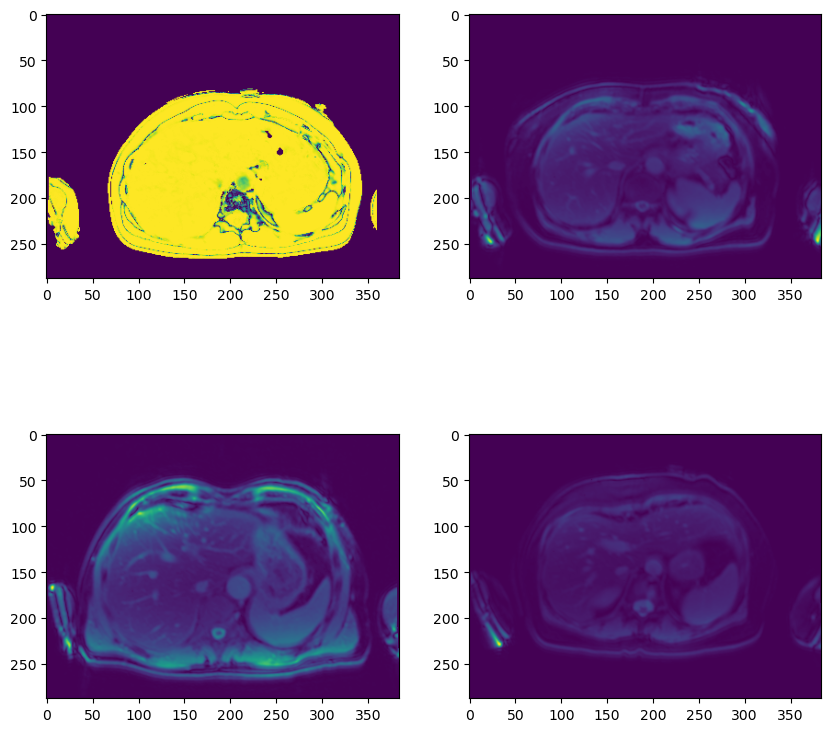

In [15]:
# the liver mri for subject 568 is bad '1134058' (568 is sorted sub in liver11.pkl)

a = orig[8,0].cpu().numpy()
b = orig[9,0].cpu().numpy()
c = orig[10,0].cpu().numpy()
d = orig[11,0].cpu().numpy()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(a)
ax[0,1].imshow(b)
ax[1,0].imshow(c)
ax[1,1].imshow(d)

Text(0, 0.5, 'InfoNCE loss')

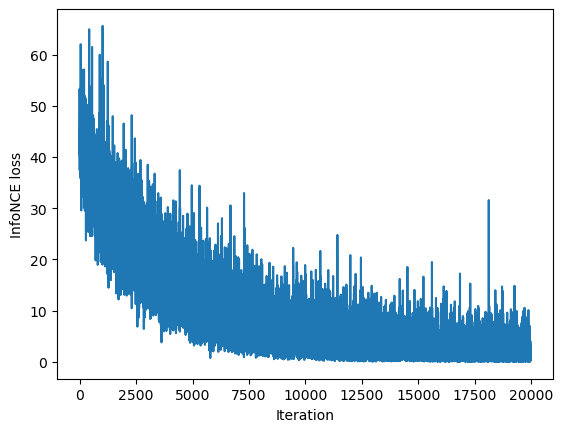

In [5]:
import matplotlib.pyplot as plt

plt.plot(trace)
plt.xlabel('Iteration')
plt.ylabel('InfoNCE loss')

In [6]:
torch.save(ext.state_dict(), "/run/media/anton/Elements/UKB/liver_feature_extract2.torch")

print('Done')

Done
